In [1]:
import pathlib, sys; sys.path.append(str(pathlib.Path(sys.path[0]).parent / "libs"))

In [2]:
import math

from tqdm import tqdm
import numpy as np
import sympy as sp
import qutip
import matplotlib.pyplot as plt

In [3]:
%reload_ext autoreload
%autoreload 2

import bec

In [4]:
n_bosons = 3
phase = 0 # np.pi / 4
# model = BEC_Qubits.init_alexey2003(n_bosons=n_bosons, phase=phase)
model = bec.BEC_Qubits.init_default(n_bosons=n_bosons, phase=phase)
print(model)
print(f"Coupling strength G = {model.G:.3e}")
print(r"\delta =", f"{model.delta:.3e}")
print(r"\frac{G^2}{\delta} =", f"{model.G**2 / model.delta:.3e}")
print(r"\frac \delta G =", f"{model.delta / model.G :.3e}", ">> 1")

BEC_Qubits(n_bosons=3, coupling_strength=1, transition_ampl=1, transition_freq=11, resonance_freq=1, phase=0)
Coupling strength G = 1.000e+00
\delta = 1.000e+01
\frac{G^2}{\delta} = 1.000e-01
\frac \delta G = 1.000e+01 >> 1


In [5]:
tspan, dt = np.linspace(0, 101, 1001, retstep=True)
init_state = bec.coherent_state_constructor(model, 0) * bec.coherent_state_constructor(model, 1) * bec.vacuum_state(model)
h = bec.h_eff_total(model)
result = qutip.mesolve(h, init_state, tspan, [], [], progress_bar=True)
states = list(result.states)

omega = -2.725e-01; d = 5.000e-04
10.1%. Run time:   0.01s. Est. time left: 00:00:00:00
20.1%. Run time:   0.03s. Est. time left: 00:00:00:00
30.1%. Run time:   0.04s. Est. time left: 00:00:00:00
40.1%. Run time:   0.05s. Est. time left: 00:00:00:00
50.0%. Run time:   0.06s. Est. time left: 00:00:00:00
60.0%. Run time:   0.08s. Est. time left: 00:00:00:00
70.0%. Run time:   0.09s. Est. time left: 00:00:00:00
80.0%. Run time:   0.10s. Est. time left: 00:00:00:00
90.0%. Run time:   0.11s. Est. time left: 00:00:00:00
Total run time:   0.12s


## Фиделити

### Фиделити всей системы

100%|████████████████████████████████████| 1001/1001 [00:00<00:00, 48329.71it/s]


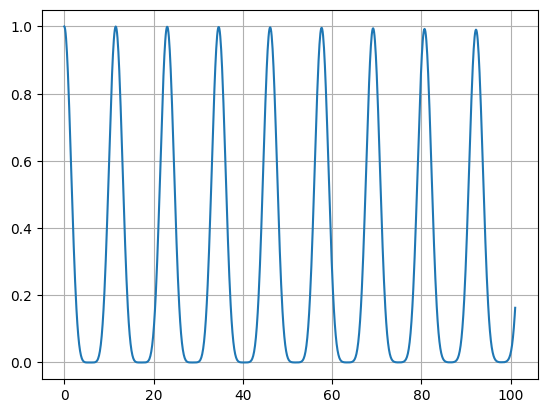

In [6]:
fidelity_span = [qutip.metrics.fidelity(init_state, s) for s in tqdm(states, ncols=80)]
plt.plot(tspan, fidelity_span)
plt.grid()

### Фиделити между кубитами

In [7]:
qutip.metrics.fidelity(qutip.ptrace(init_state * init_state.dag(), [0, 1]), qutip.ptrace(init_state * init_state.dag(), [2, 3]))

0.9999999999999996

100%|██████████████████████████████████████| 1001/1001 [00:01<00:00, 921.64it/s]


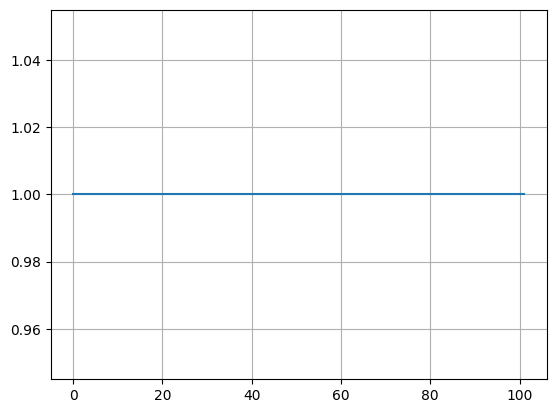

In [8]:
fidelity_span12 = [np.round(qutip.metrics.fidelity(qutip.ptrace(s * s.dag(), [0, 1]), qutip.ptrace(s * s.dag(), [2, 3])), 7) for s in tqdm(states, ncols=80)]
plt.plot(tspan, fidelity_span12)
plt.grid()

### Фиделити первого и второго

100%|██████████████████████████████████████| 1001/1001 [00:01<00:00, 937.18it/s]


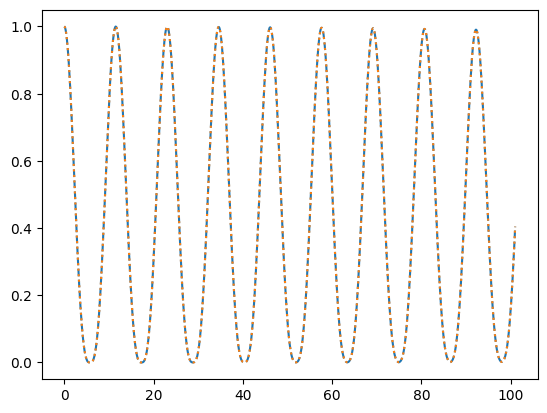

In [9]:
init_rho = init_state * init_state.dag()
init_rho1 = qutip.ptrace(init_rho, [2, 3])
init_rho2 = qutip.ptrace(init_rho, [0, 1])
fidelity_span1 = [np.round(qutip.metrics.fidelity(init_rho1, qutip.ptrace(s * s.dag(), [2, 3])), 7) for s in tqdm(states, ncols=80)]
fidelity_span2 = [np.round(qutip.metrics.fidelity(init_rho2, qutip.ptrace(s * s.dag(), [0, 1])), 7) for s in tqdm(states, ncols=80)]
plt.plot(tspan, fidelity_span1, '--')
plt.plot(tspan, fidelity_span2, ':')

## Среднее значене Sz

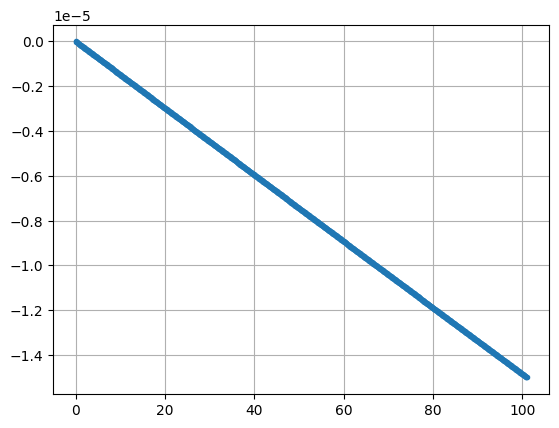

In [10]:
e_opts = [bec.sz(model, 0) + bec.sz(model, 1)]
r = qutip.mesolve(h, init_state, tspan, [], e_opts)
plt.plot(tspan, r.expect[0], ".-")
plt.grid()